In [183]:
import numpy as np


def loss(y_true, y_pred):
    return np.sum((y_true - y_pred) ** 2)


def loss_d(y_true, y_pred):
    return 2 * y_pred - 2 * y_true


def sigm_fun(x):
    return 1 / (1 + np.exp(-x))


def sigm_d(sigm_val):
    return sigm_val * (1 - sigm_val)


def relu(x):
    return 0 if x < 0 else x


def relu_d(relu_val):
    return 0 if relu_val <= 0 else 1


def softmax(outputs):
    exp_outputs = [math.exp(o) for o in outputs]
    total = sum(exp_outputs)
    return [eo / total for eo in exp_outputs]


def cross_entropy_loss(y_true, y_pred):
    y_true = int(y_true - 1)
    return -(
        y_true * np.log(y_pred + 1e-10) + (1 - y_true) * np.log(1 - y_pred + 1e-10)
    )


def cross_entropy_loss_d(y_true, y_pred):
    y_true = int(y_true - 1)
    return y_pred - y_true


class Neuron:
    def __init__(self, rng, input_dim, activation_f, activation_f_d):
        self.activation_f = activation_f
        self.activation_f_d = activation_f_d
        weight_list = []
        for i in range(input_dim):
            weight_list.append(rng.uniform(-1, 1))
        self.weights = np.asarray(weight_list)
        self.b = rng.uniform(-1, 1)
        self.b_grad = 0
        self.w_grad = np.zeros(input_dim)
        self.out_grad = 0

    def work(self, inputs):
        self.x = np.array(inputs)
        sum = np.sum(inputs * self.weights) + self.b
        self.output = self.activation_f(sum)
        return self.output

    def x_grad(self, i):
        return self.out_grad * self.activation_f_d(self.output) * self.weights[i]

    def generate_param_grad(self):
        self.w_grad = self.out_grad * self.activation_f_d(self.output) * self.x
        self.b_grad = self.out_grad * self.activation_f_d(self.output)

    def update_weights(self, errors, learning_rate):
        for i in range(len(self.weights)):
            self.weights[i] -= learning_rate * errors[i] * self.x[i]


class NeuralNet:
    def __init__(
        self,
        number_of_neurons_in_layer,
        hidden_layers,
        input_dim,
        number_of_outputs=1,
        seed=10,
        activation_f="sigmoid",
    ):
        if activation_f == "sigmoid":
            act_f = sigm_fun
            act_f_d = sigm_d
        elif activation_f == "relu":
            act_f = relu
            act_f_d = relu_d
        else:
            print("Allowed activation_function values are {'sigmoid', 'relu'}")
            return

        self.rng = np.random.default_rng(seed)
        self.layers = []
        self.neurons: list[Neuron] = []
        layer_1 = [
            Neuron(self.rng, input_dim, act_f, act_f_d)
            for _ in range(number_of_neurons_in_layer)
        ]
        self.layers.append(layer_1)
        self.neurons.extend(layer_1)
        for i in range(hidden_layers - 1):
            current_layer = [
                Neuron(self.rng, number_of_neurons_in_layer, act_f, act_f_d)
                for _ in range(number_of_neurons_in_layer)
            ]
            self.neurons.extend(current_layer)
            self.layers.append(current_layer)
        output_layer = []
        for i in range(number_of_outputs):
            output_neuron = Neuron(
                self.rng,
                number_of_neurons_in_layer,
                activation_f=lambda x: x,
                activation_f_d=lambda x: 1,
            )
            output_layer.append(output_neuron)
            self.neurons.append(output_neuron)
        self.layers.append(output_layer)

    def predict_regre(self, inputs):
        outputs = inputs.copy()
        for layer in self.layers:
            outputs = [neuron.work(outputs) for neuron in layer]
        return outputs[0]

    def predict_class(self, inputs):
        outputs = inputs.copy()
        for layer in self.layers:
            outputs = [neuron.work(outputs) for neuron in layer]
        probabilitie = sigm_fun(outputs[0])

        return probabilitie

    def backprop_single_input(self, input, expected_value):
        y_pred = self.predict_regre(input)
        error = loss(expected_value, y_pred)
        error_d = loss_d(y_pred=y_pred, y_true=expected_value)
        output_neuron = self.layers[-1][0]
        output_neuron.out_grad = error_d
        output_neuron.generate_param_grad()
        next_layer = self.layers[-1]
        for layer in reversed(self.layers[:-1]):
            for i, neuron in enumerate(layer):
                neuron.w_grad = 0
                neuron.out_grad = 0
                neuron.b_grad = 0
                for next_neuron in next_layer:
                    neuron.out_grad += next_neuron.x_grad(i)
                neuron.generate_param_grad()
        return error

    def train_regre(
        self, X, Y, learning_rate=0.05, epochs=50, print_logs=False, batch_size=50
    ):
        n = min(batch_size, len(X))
        for k in range(epochs):
            tot_error = 0
            tot_grad = [(0, 0) for neuron in self.neurons]
            batch_ind = self.rng.integers(low=0, high=len(X), size=n)
            for x, y in zip(X[batch_ind], Y[batch_ind]):
                tot_error += self.backprop_single_input(x, y)
                tot_grad = [
                    (grad[0] + neuron.w_grad, grad[1] + neuron.b_grad)
                    for grad, neuron in zip(tot_grad, self.neurons)
                ]
            tot_error = tot_error / n
            for grad, neuron in zip(tot_grad, self.neurons):
                neuron.weights -= grad[0] / n * learning_rate
                neuron.b -= grad[1] / n * learning_rate
            if print_logs:
                print(f"Epoch: {k}, mean loss: {tot_error}")

    def backprop_binary_input(self, input, expected_value):
        y_pred = self.predict_class(input)
        error = cross_entropy_loss(expected_value, y_pred)
        error_d = cross_entropy_loss_d(y_pred=y_pred, y_true=expected_value)
        output_neuron = self.layers[-1][0]
        output_neuron.out_grad = error_d
        output_neuron.generate_param_grad()
        next_layer = self.layers[-1]
        for layer in reversed(self.layers[:-1]):
            for i, neuron in enumerate(layer):
                neuron.w_grad = 0
                neuron.out_grad = 0
                neuron.b_grad = 0
                for next_neuron in next_layer:
                    neuron.out_grad += next_neuron.x_grad(i)
                neuron.generate_param_grad()
        return error

    def train_class(
        self, X, Y, learning_rate=0.05, epochs=50, print_logs=False, batch_size=50
    ):
        n = min(batch_size, len(X))
        for k in range(epochs):
            tot_error = 0
            tot_grad = [(0, 0) for neuron in self.neurons]
            batch_ind = self.rng.integers(low=0, high=len(X), size=n)
            for x, y in zip(X[batch_ind], Y[batch_ind]):
                tot_error += self.backprop_binary_input(x, y)
                tot_grad = [
                    (grad[0] + neuron.w_grad, grad[1] + neuron.b_grad)
                    for grad, neuron in zip(tot_grad, self.neurons)
                ]
            tot_error = tot_error / n
            for grad, neuron in zip(tot_grad, self.neurons):
                neuron.weights -= grad[0] / n * learning_rate
                neuron.b -= grad[1] / n * learning_rate
            if print_logs:
                print(f"Epoch: {k}, mean loss: {tot_error}")

In [51]:
import math

def evaluate_model_regre(model, X, Y):
    Y_pred = [model.predict_regre(x) for x in X]
    MSE = sum([(y_pred - y)**2 for y_pred, y in zip(Y_pred,Y)]) / len(Y)
    return math.sqrt(MSE)


def evaluate_model_class(model, X, Y):
    Y_pred = [model.predict_regre(x)  for x in X]
    MSE = sum([(y_pred - y-1)**2 for y_pred, y in zip(Y_pred,Y)]) / len(Y)
    return math.sqrt(MSE)

In [52]:
net = NeuralNet(hidden_layers=3,number_of_neurons_in_layer=3,input_dim=3)


x = [2,3,6]
y = 10
net.train_regre([x], [y])
net.predict_regre(x)

np.float64(9.999999204241814)

In [164]:
def scale(X, min, max):
    return (X.astype(float) - min) / (max - min)

In [ ]:
def rescale(x, min, max):
    return x * (max - min) + min

In [188]:
train_data = np.genfromtxt('./projekt1/regression/data.activation.train.1000.csv', delimiter=',')
test_data = np.genfromtxt('./projekt1/regression/data.activation.test.1000.csv', delimiter=',')
X_train = train_data[1:, 0]
Y_train = train_data[1:, 1]
X_test = test_data[1:, 0]
Y_test = test_data[1:, 1]

net = NeuralNet(hidden_layers=3,number_of_neurons_in_layer=30,input_dim=1, activation_f='sigmoid')
net.train_regre(X_train, Y_train, learning_rate=0.005, epochs=1000, print_logs=True)

print(f"RMSE on train data {evaluate_model_regre(net, X_train, Y_train)}")
print(f"RMSE on test data {evaluate_model_regre(net, X_test, Y_test)}")

Epoch: 0, mean loss: 11137.00366987708
Epoch: 1, mean loss: 12935.593284597273
Epoch: 2, mean loss: 11428.39825496475
Epoch: 3, mean loss: 12374.514450828963
Epoch: 4, mean loss: 11455.103352802264
Epoch: 5, mean loss: 10184.446718409356
Epoch: 6, mean loss: 10923.06700200497
Epoch: 7, mean loss: 8405.666952816542
Epoch: 8, mean loss: 7267.259260206574
Epoch: 9, mean loss: 8947.378247182107
Epoch: 10, mean loss: 6992.929083824208
Epoch: 11, mean loss: 4965.290718768502
Epoch: 12, mean loss: 2848.6033917942777
Epoch: 13, mean loss: 4418.860433803532
Epoch: 14, mean loss: 3481.1908689669845
Epoch: 15, mean loss: 3031.5110108483204
Epoch: 16, mean loss: 2828.9119166558203
Epoch: 17, mean loss: 2855.937451484145
Epoch: 18, mean loss: 1347.428309206513
Epoch: 19, mean loss: 2301.8034509888003
Epoch: 20, mean loss: 972.4324073336127
Epoch: 21, mean loss: 2060.2877276422796
Epoch: 22, mean loss: 1418.054694167378
Epoch: 23, mean loss: 1111.6015006834243
Epoch: 24, mean loss: 1787.683619754021

In [181]:
train_data = np.genfromtxt(
    "./projekt1/regression/data.activation.train.1000.csv", delimiter=","
)
test_data = np.genfromtxt(
    "./projekt1/regression/data.activation.test.1000.csv", delimiter=","
)
X_train = train_data[1:, 0]
Y_train = train_data[1:, 1]
X_test = test_data[1:, 0]
Y_test = test_data[1:, 1]
minx = min(X_train)
maxx = max(X_train)
miny = min(Y_train)
maxy = max(Y_train)

net = NeuralNet(
    hidden_layers=3, number_of_neurons_in_layer=30, input_dim=1, activation_f="sigmoid"
)
X_scaled = scale(X_train, minx, maxx)
Y_scaled = scale(Y_train, miny, maxy)
Y_test_scaled = scale(Y_test, miny, maxy)
X_test_scaled = scale(X_test, minx, maxx)
net.train_regre(X_scaled, Y_scaled, learning_rate=0.0001, epochs=1000, print_logs=True)

print(f"RMSE on train data {evaluate_model_regre(net, X_scaled, Y_scaled)}")
print(f"RMSE on test data {evaluate_model_regre(net, X_test_scaled, Y_test_scaled)}")

Epoch: 0, mean loss: 0.3984525416208911
Epoch: 1, mean loss: 0.366339643928162
Epoch: 2, mean loss: 0.34638769914633327
Epoch: 3, mean loss: 0.28714429020747123
Epoch: 4, mean loss: 0.3065706653269608
Epoch: 5, mean loss: 0.3029060382994512
Epoch: 6, mean loss: 0.30628355073279545
Epoch: 7, mean loss: 0.31009743039721577
Epoch: 8, mean loss: 0.40719146656425537
Epoch: 9, mean loss: 0.2897712282726774
Epoch: 10, mean loss: 0.35025268578215785
Epoch: 11, mean loss: 0.3825070457276965
Epoch: 12, mean loss: 0.3627160337099033
Epoch: 13, mean loss: 0.3164680144465983
Epoch: 14, mean loss: 0.3266955596265494
Epoch: 15, mean loss: 0.32744176141435133
Epoch: 16, mean loss: 0.33062226126622707
Epoch: 17, mean loss: 0.34497722920310975
Epoch: 18, mean loss: 0.3552176119891089
Epoch: 19, mean loss: 0.29854301778475656
Epoch: 20, mean loss: 0.4417799026656195
Epoch: 21, mean loss: 0.3053060650035949
Epoch: 22, mean loss: 0.31876843946768374
Epoch: 23, mean loss: 0.34025744303919425
Epoch: 24, mean

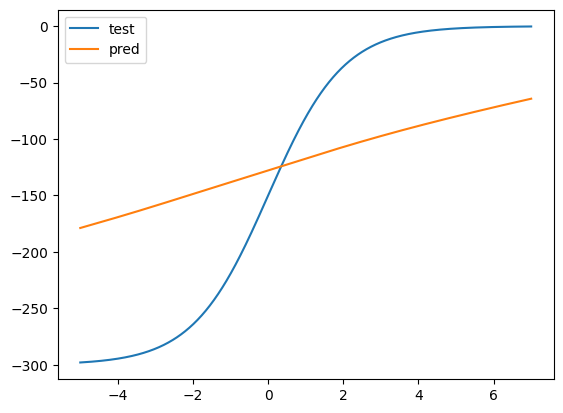

In [189]:
import matplotlib.pyplot as plt
ind = np.argsort(X_train)
plt.plot(X_test, Y_test, label = 'test')
Y_pred = [net.predict_regre(x) for x in X_test_scaled]
plt.plot(X_test, Y_pred, label = 'pred')
plt.legend()

# Classifcation

In [87]:
train_data = np.genfromtxt('./projekt1/classification/data.simple.train.1000.csv', delimiter=',')
test_data = np.genfromtxt('./projekt1/classification/data.simple.test.1000.csv', delimiter=',')
X_train = train_data[1:, :2]
Y_train = train_data[1:, 2]
X_test = test_data[1:, :2]
Y_test = test_data[1:, 2]

net = NeuralNet(hidden_layers=3,number_of_neurons_in_layer=30,input_dim=2, number_of_outputs = 1)
net.train_class(X_train, Y_train, learning_rate=0.01, epochs=1000, print_logs=True)

print(f"RMSE on train data {evaluate_model_class(net, X_train, Y_train)}")
print(f"RMSE on test data {evaluate_model_class(net, X_test, Y_test)}")

Epoch: 0, mean loss: 0.7222313366807325
Epoch: 1, mean loss: 0.7079687916685765
Epoch: 2, mean loss: 0.7177947817388799
Epoch: 3, mean loss: 0.6546032355629159
Epoch: 4, mean loss: 0.6882344710323969
Epoch: 5, mean loss: 0.7315221480296907
Epoch: 6, mean loss: 0.7382933309331251
Epoch: 7, mean loss: 0.704338695884059
Epoch: 8, mean loss: 0.7193432658602853
Epoch: 9, mean loss: 0.7231943481897298
Epoch: 10, mean loss: 0.7025712190266443
Epoch: 11, mean loss: 0.7180388775805965
Epoch: 12, mean loss: 0.7276633179048241
Epoch: 13, mean loss: 0.6959841839728328
Epoch: 14, mean loss: 0.709975845570917
Epoch: 15, mean loss: 0.7090893955274011
Epoch: 16, mean loss: 0.6991328396398009
Epoch: 17, mean loss: 0.70407234496312
Epoch: 18, mean loss: 0.6928996774344666
Epoch: 19, mean loss: 0.7043617963751068
Epoch: 20, mean loss: 0.694386518760964
Epoch: 21, mean loss: 0.6914342375004012
Epoch: 22, mean loss: 0.6806981263811772
Epoch: 23, mean loss: 0.6946766753685745
Epoch: 24, mean loss: 0.6983008

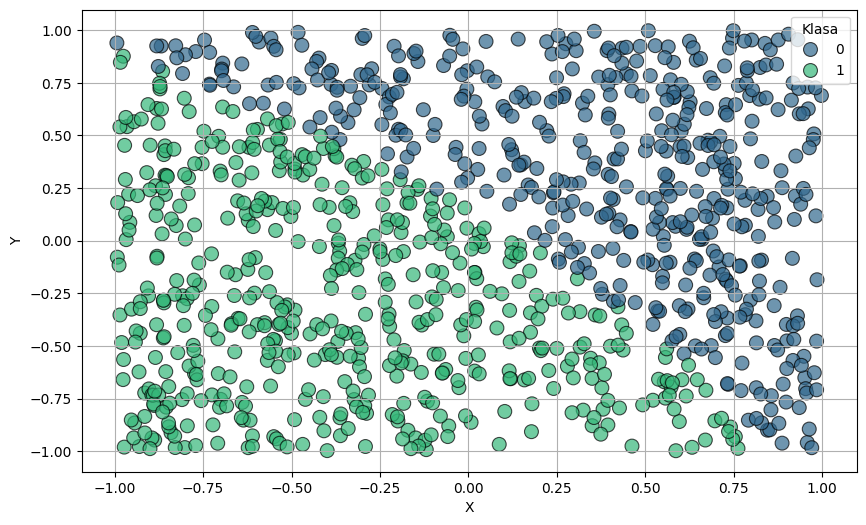

In [88]:
import seaborn as sns
X_test = test_data[1:, 0]
Y_test = test_data[1:, 1]
C_test = test_data[1:, 2]

# Create a scatter plot using Seaborn
plt.figure(figsize=(10, 6))

# Use scatterplot with NumPy arrays
Y_pred = [0 if net.predict_class(input) < 0.5 else 1 for input in test_data[1:, :2]]
sns.scatterplot(x=X_test, y=Y_test, hue=Y_pred, palette='viridis', s=100, edgecolor='k', alpha=0.7)

# Add labels and title
plt.xlabel('X')
plt.ylabel('Y')
plt.legend(title='Klasa')
plt.grid(True)